# A basic model to try and price the value of an asset

In [183]:
import numpy as np
import pandas as pd
from scipy.optimize import root
import matplotlib.pyplot as plt

Starting Parameters

In [184]:
R = 0.065
b = 1/(1+R)
maturity_g = 0.03
time_frame = 25
start_earnings = 10
k_vec_m = 1 + maturity_g
maturity_multiple = (k_vec_m*b*(1-(k_vec_m*b)**18)/(1-b*k_vec_m))
maturity_multiple

13.301842534407836

```python
# initial low growth for 5 periods
initial_growth = np.linspace(0.06, 0.10, 2)

# accelerated growth for 10 periods
accelerated_growth = np.linspace(0.10, 0.40, 5)

decelerated_growth = np.linspace(0.40, 0.10, 5)

# decelerated growth for 5 periods
sustained_growth = np.linspace(0.10, 0.05, 5)

# stable mature growth for 5 periods
mature_growth = np.linspace(0.05, 0.03, 8)

# concatenate all growth periods to form the 25 period list
earnings_growth = (np.concatenate((initial_growth, accelerated_growth, decelerated_growth, sustained_growth, mature_growth)))
earnings_growth
#earnings_growth = [0.06,0.10,0.20,0.30,0.35,0.37,0.40,0.31,0.22,0.11, 0.13, 0.09, 0.08, 0.085]

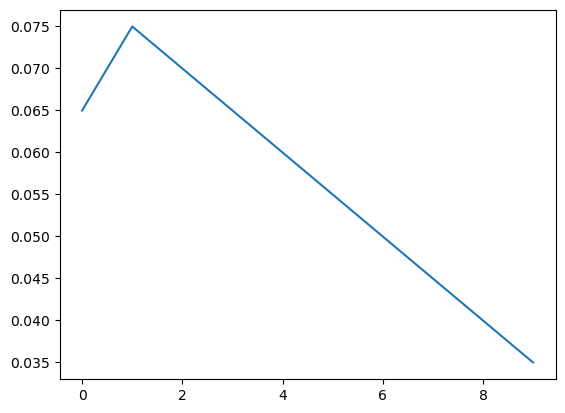

In [185]:
def predict_growth(start_value, len: int = 10):
    # Initialize the list with the first two values
    g_vec = [start_value + 0.005, start_value + 0.015]
    
    # Calculate the decrement needed to reach 0.035 in len-2 steps
    decrement = (g_vec[-1] - 0.035) / (len-2)

    # Add the next five values to the list
    for i in range(len-2):
        g_vec.append(g_vec[-1] - decrement)
    
    return g_vec
plt.plot(range(len(predict_growth(0.06))), predict_growth(0.06))
plt.show()

In [186]:
growth = [1 + g for g in predict_growth(0.06)]
display(growth)
import numpy as np
k_vec = np.cumprod(growth)
k_vec


[1.065, 1.075, 1.07, 1.065, 1.06, 1.055, 1.05, 1.045, 1.04, 1.035]

array([1.065     , 1.144875  , 1.22501625, 1.30464231, 1.38292084,
       1.45898149, 1.53193057, 1.60086744, 1.66490214, 1.72317371])

In [187]:
def predict_multiple(start_value: float = 0.04):
    growth = [1 + g for g in predict_growth(start_value, len=8)]
    b_vec = [b] * len(growth)
    k_vec = np.cumprod(growth)
    b_vec = np.cumprod(b_vec)
    return sum(k_vec*b_vec) + maturity_multiple*b_vec[-1]*k_vec[-1]
predict_multiple()

18.86328020851085

In [188]:




# Define the logistic function
def logistic_function(t, L, k, t0, c, a):
    return c + (L / (1 + np.exp(-(k*(t-t0)-a))))

# Apply the logistic function to time
L = start_earnings*((1+maturity_g)**time_frame)
print(L)  # Maximum value

t0 = 0  # Midpoint
a = 5 # Shifting the curve
g = maturity_g
x0 = 15
c = 10 
k=0.50

# Define the time period
time = np.arange(0, 25, 1)  # For example, 10 years with 0.1 year interval

def mature_growth(start_y, g, x0, x):
    return start_y*((1+g)**(x-x0))

def mature_growth_gradient(start_y, g, x0, x):
    return start_y * np.log(1+g) * (1+g)**(x-x0)

# Calculate the earnings
# Define the derivative of the logistic function
def logistic_derivative(t, L, k, t0, c, a):
    e = np.exp(-(k*(t-t0)-a))
    return (L * k * e) / ((1 + e) ** 2)


start_y = logistic_function(x0, L, k, t0, c, a)

# Define the equation to solve
def equation(k):
    return logistic_derivative(15, L, k, t0, c, a) - mature_growth_gradient(start_y, g, 15, 15)

# Solve for k
solution = root(equation, 0)  # 0 is the initial guess
k_solution = solution.x[0]

print(f"The solution for k is {k_solution}")
#k = k_solution  # Steepness of the curve


#- logistic_function(0, L, k, t0, c = 0, a=5)





20.93777929654216
The solution for k is 0.24651473528320694


In [189]:
mature_growth(start_y, g, x0, x0)

29.34947746542

In [190]:
logistic_function(5, L, k, t0, c, a)

11.58830183112216

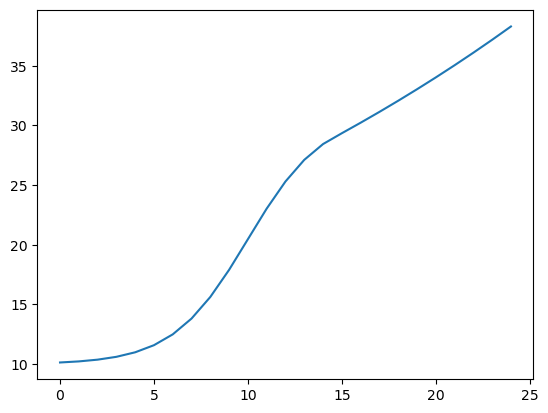

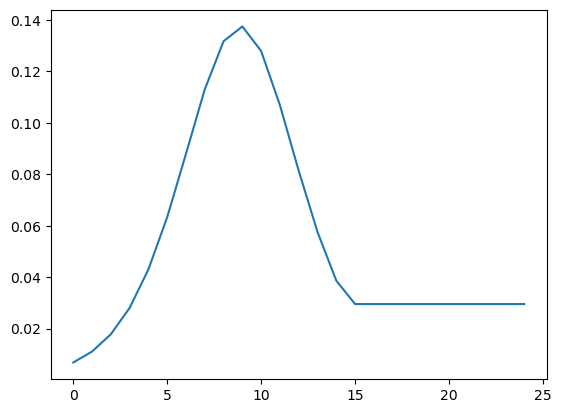

In [191]:
def earnings_func(x, L=L, k=k, t0=t0, a=a, c=c, g=g, x0=x0, start_y=start_y):
    if x < x0:
        return logistic_function(x, L, k, t0, c, a)
    else:
        return mature_growth(start_y, g, x0, x)
    
earnings = [earnings_func(t) for t in time]
earnings_growth = [(logistic_derivative(t, L, k, t0, c, a))/earnings_func(t) if t<x0 else (mature_growth_gradient(start_y, g, x0, t))/earnings_func(t) for t in time]
    
plt.plot(time, earnings)
plt.show()

plt.plot(time, earnings_growth)
plt.show()
    
    
#earnings_func(time)
#time>x0

In [192]:

asset_df = pd.DataFrame({'earnings': earnings, 'earnings_growth': earnings_growth})

In [193]:
def gen_earnings(df: pd.DataFrame = asset_df): 
    earnings = [10]
    earnings.extend(list(np.zeros(len(earnings_growth)-1)))
    df['earnings'] = earnings
    for i, g in zip(df.index[1:], df.earnings_growth[1:]):
        #print(asset_df.loc[i, 'earnings'])
        df.loc[i, 'earnings'] = df.loc[i-1, 'earnings']*(1+g)
    df.earnings = df.earnings.round(1)
    return None


The multiples assume that growth continues at the current rate for a certain set of years and then trails back down to maturity

In [194]:
def gen_multiples(df: pd.DataFrame = asset_df):
    multiples = [20]
    multiples.extend(list(np.zeros(len(earnings_growth)-1)))
    df['multiples'] = multiples
    k_v = asset_df.earnings_growth[1:]
    df.loc[1:, 'multiples'] =  k_v.apply(predict_multiple)
    #(k_vec*b*(1-(k_vec*b)**7))/(1-b*k_vec)
    return None

In [195]:
def gen_mkt_cap(df: pd.DataFrame = asset_df):
    asset_df['mkt_cap'] = asset_df.earnings*asset_df.multiples
    return None

In [196]:
def gen_cum_earnings(df: pd.DataFrame = asset_df):
    df['cum_earnings'] = df['earnings'].cumsum()
    return None


In [197]:
def gen_roi(df: pd.DataFrame = asset_df):
    roi = [0]
    roi.extend(list(np.zeros(len(earnings_growth)-1)))
    df['roi'] = roi
    df.loc[1:,'roi'] = ((df.loc[1:,'mkt_cap'] + df.loc[1:,'cum_earnings'])/df['mkt_cap'][0])**(1/df.index[1:]) - 1

    return None

In [198]:
def gen_props_of_return(df: pd.DataFrame = asset_df):
    df['appreciation_prop'] = (df['mkt_cap'] - df['mkt_cap'][0])/(df['mkt_cap']  - df['mkt_cap'][0] + df['cum_earnings'])
    df['earnings_prop'] = df['cum_earnings']/(df['mkt_cap']  - df['mkt_cap'][0] + df['cum_earnings'])
    return None

In [199]:
def gen_extra_cols(pre_genned = True):
    if pre_genned == False:
        asset_df = pd.DataFrame({'earnings_growth': earnings_growth})
        gen_earnings()        
    else:
        asset_df = pd.DataFrame({'earnings_growth': earnings_growth, 'earnings': earnings})
    gen_multiples()
    gen_mkt_cap()
    gen_cum_earnings()
    gen_roi()
    gen_props_of_return()
    return None

In [200]:
gen_extra_cols()

In [201]:
asset_df = asset_df.round(2)
asset_df


,earnings,earnings_growth,multiples,mkt_cap,cum_earnings,roi,appreciation_prop,earnings_prop
0,10.14,0.01,20.00,202.80,10.14,0.00,0.00,1.00
1,10.23,0.01,16.87,172.59,20.37,-0.05,3.07,-2.07
2,10.38,0.02,17.32,179.68,30.75,0.02,-3.03,4.03
3,10.61,0.03,18.02,191.22,41.36,0.05,-0.39,1.39
4,10.99,0.04,19.08,209.78,52.35,0.07,0.12,0.88
5,11.59,0.06,20.62,238.92,63.94,0.08,0.36,0.64
6,12.50,0.09,22.62,282.64,76.44,0.10,0.51,0.49
7,13.82,0.11,24.82,343.00,90.26,0.11,0.61,0.39
8,15.63,0.13,26.58,415.50,105.89,0.13,0.67,0.33
9,17.90,0.14,27.14,485.98,123.79,0.13,0.70,0.30


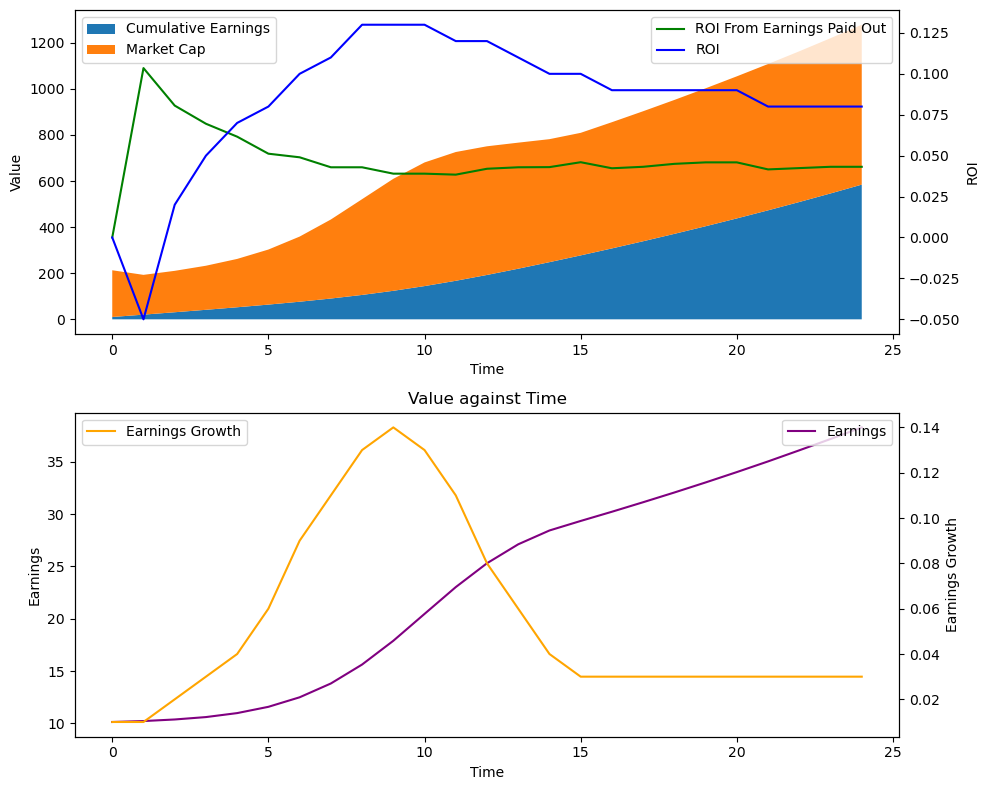

In [204]:
fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(10, 8))  # Create a new figure and two subplots

# First subplot for Market Cap and Cumulative Earnings
# Use fill_between function instead of bar to create stacked area chart
ax1.fill_between(asset_df.index, asset_df.cum_earnings, label='Cumulative Earnings')
ax1.fill_between(asset_df.index, asset_df.cum_earnings + asset_df.mkt_cap, asset_df.cum_earnings, label='Market Cap')

ax1.set_xlabel('Time')  # Add an x-label to the axes.
ax1.set_ylabel('Value')  # Add a y-label to the axes.
ax1.legend(loc='upper left')  # Add a legend.

# Create a secondary axis for the first subplot
ax1b = ax1.twinx()
ax1b.plot(asset_df.index, asset_df.earnings_prop * asset_df.roi, label='ROI From Earnings Paid Out', color='green')
ax1b.plot(asset_df.index, asset_df.roi, label='ROI', color='blue')
ax1b.set_ylabel('ROI')  # Add a y-label to the axes.
ax1b.legend(loc='upper right')  # Add a legend.

# Second subplot for Earnings
ax3.plot(asset_df.index, asset_df.earnings, label='Earnings', color='purple')  # Plot the 'earnings' series on the second y-axis
ax3.set_xlabel('Time')  # Add an x-label to the axes.
ax3.set_ylabel('Earnings')  # Add a y-label to the axes.
ax3.legend(loc='upper right')  # Add a legend.

# Create a secondary axis for the second subplot
ax3b = ax3.twinx()
ax3b.plot(asset_df.index, asset_df.earnings_growth, label='Earnings Growth', color='orange')  # Plot the 'earnings_growth' series on the second y-axis
ax3b.set_ylabel('Earnings Growth')  # Add a y-label to the axes.
ax3b.legend(loc='upper left')  # Add a legend.

plt.title('Value against Time')  # Add a title to the plot
plt.tight_layout()  # Adjust the layout
plt.show()  # Display the plot
